# **1. Install packages**

In [1]:
!pip install catboost

# **2. Import libraries**

In [2]:
## Data handling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import missingno as msno # missing values visualization

## Stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import norm

## Preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

## Classes Imbalance
from imblearn.over_sampling import SMOTE

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


## Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Time
import time

## Warnings
import warnings
warnings.filterwarnings('ignore')

# **3. Load data**

In [3]:
data = pd.read_csv('/kaggle/input/sleepy-driver-eeg-brainwave-data/acquiredDataset.csv')
data.head()

attention  meditation   delta   theta  lowAlpha  highAlpha  lowBeta  \
0         26          34  960462  277180     26575      27356    26575   
1         29          54   39145   28225     20172      39551    20172   
2         40          48   75410   43144      8601      13564     8601   
3         66          47   16057   41211      2534      34254     2534   
4         81          67   10304   47239     33158      47349    33158   

   highBeta  lowGamma  highGamma  classification  
0     13056      9126       2683               0  
1      9933      5237       4750               0  
2     11663      2515       3251               0  
3     27663     11396       2825               0  
4     16328      5298       5471               0

In [4]:
print(f'Data size: {data.shape[0]} rows and {data.shape[1]} columns')

Data size: 3735 rows and 11 columns


In [5]:
print("**"*30)
print("**", "Data set Information")
print("**"*30)
print(data.info())

************************************************************
** Data set Information
************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3735 entries, 0 to 3734
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   attention       3735 non-null   int64
 1   meditation      3735 non-null   int64
 2   delta           3735 non-null   int64
 3   theta           3735 non-null   int64
 4   lowAlpha        3735 non-null   int64
 5   highAlpha       3735 non-null   int64
 6   lowBeta         3735 non-null   int64
 7   highBeta        3735 non-null   int64
 8   lowGamma        3735 non-null   int64
 9   highGamma       3735 non-null   int64
 10  classification  3735 non-null   int64
dtypes: int64(11)
memory usage: 321.1 KB
None


# **4. EDA**

In [6]:
# We check for duplicate rows.
print('Duplicate rows:')
print(data.duplicated().sum())

Duplicate rows:
0


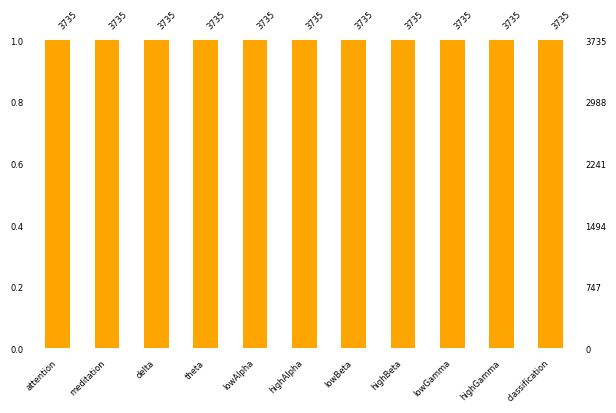

In [7]:
# We check for missing values.
fig,ax = plt.subplots(figsize = (7,4))
msno.bar(data, color = 'orange', fontsize = 6, ax = ax)
fig.show()

In [8]:
# We select the numerical columns that we want to plot.
cols_to_plot = data.columns.drop('classification').to_list()
cols_to_plot

['attention',
 'meditation',
 'delta',
 'theta',
 'lowAlpha',
 'highAlpha',
 'lowBeta',
 'highBeta',
 'lowGamma',
 'highGamma']

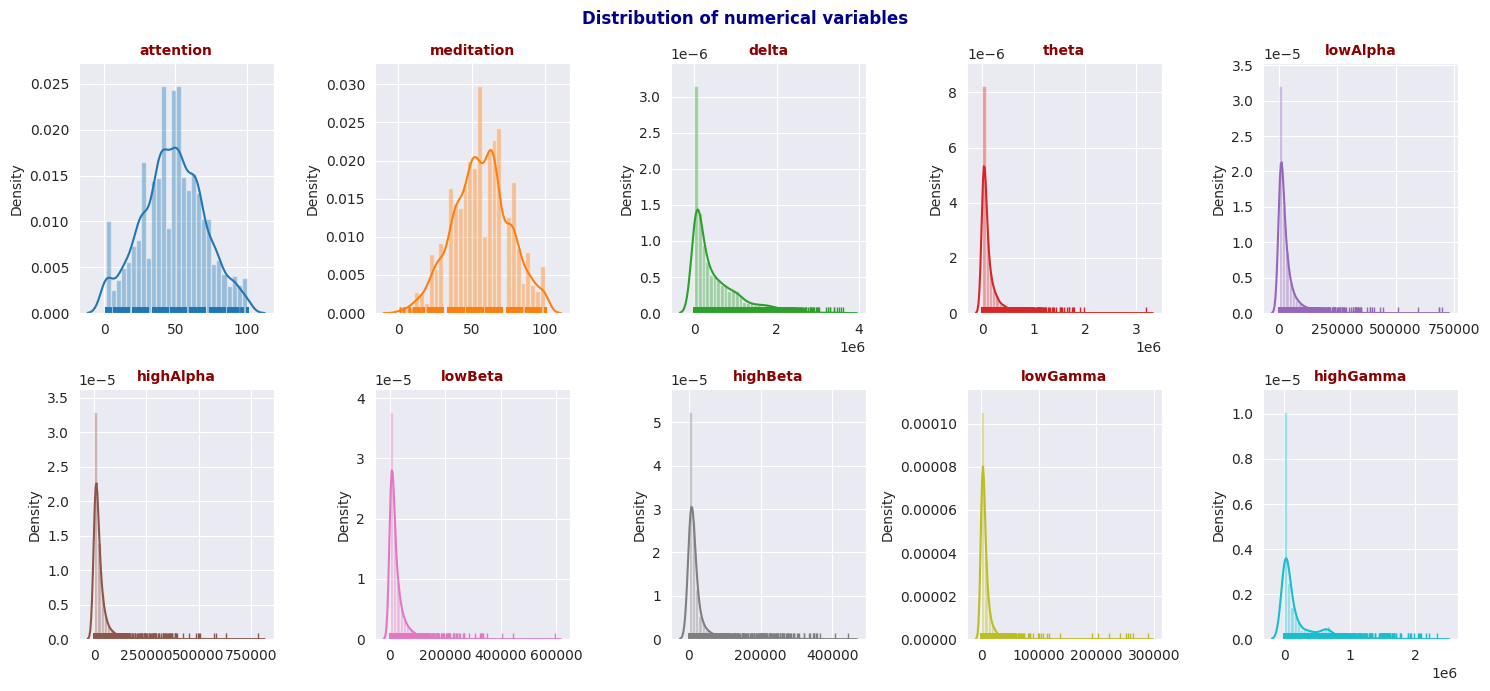

In [9]:
# Let's visualize the distribution of numerical variables.
sns.set_style('darkgrid')

fig,ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15,7))
ax = ax.flat

for i,col in enumerate(cols_to_plot):

    sns.distplot(data[col],
                 rug = True,
                 color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
                 ax = ax[i])

    ax[i].set_xlabel('')
    ax[i].set_title(f'{col}', fontsize = 10, fontweight = 'bold', color = 'darkred')

fig.suptitle('Distribution of numerical variables', fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.tight_layout()
fig.show()

In [10]:
# Now let's check your skewness and kurtosis of each numerical variable.

for col in cols_to_plot:
  print(f"* {col}:")
  print("Skewness: %f" % data[col].skew())
  print("Kurtosis: %f" % data[col].kurt())
  print("=================================")


* attention:
Skewness: -0.010962
Kurtosis: -0.331319
* meditation:
Skewness: -0.029183
Kurtosis: -0.241963
* delta:
Skewness: 1.657414
Kurtosis: 2.794362
* theta:
Skewness: 4.030050
Kurtosis: 25.031529
* lowAlpha:
Skewness: 4.852354
Kurtosis: 37.221024
* highAlpha:
Skewness: 5.464175
Kurtosis: 41.974266
* lowBeta:
Skewness: 4.710650
Kurtosis: 37.112745
* highBeta:
Skewness: 4.411688
Kurtosis: 22.765440
* lowGamma:
Skewness: 9.905020
Kurtosis: 138.982167
* highGamma:
Skewness: 2.393601
Kurtosis: 6.698709


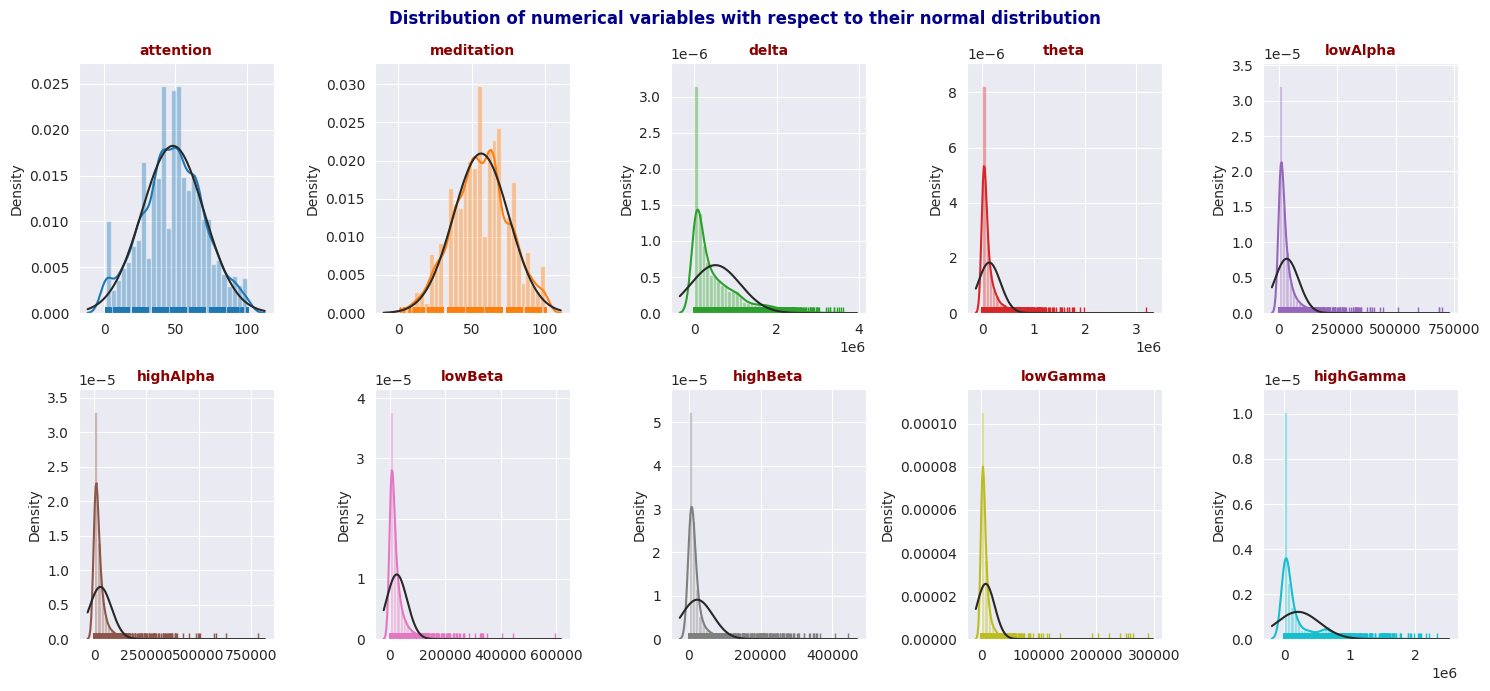

In [11]:
# Let's visualize the distribution of each numerical variable and what the normal distribution of each of them would look like.
fig,ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15,7))
ax = ax.flat

for i,col in enumerate(cols_to_plot):

    sns.distplot(data[col],
                 rug = True,
                 fit = norm,
                 color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
                 ax = ax[i])

    ax[i].set_xlabel('')
    ax[i].set_title(f'{col}', fontsize = 10, fontweight = 'bold', color = 'darkred')

fig.suptitle('Distribution of numerical variables with respect to their normal distribution', fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.tight_layout()
fig.show()

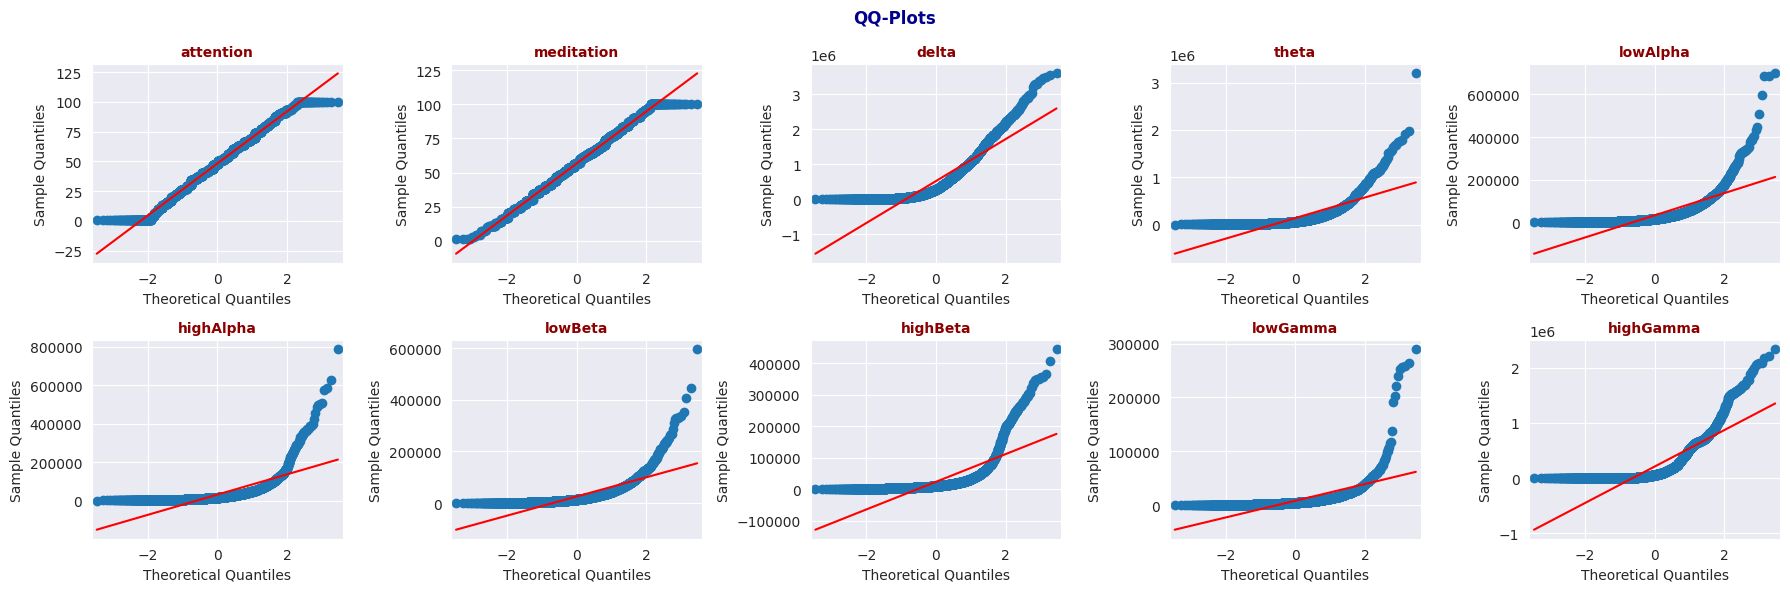

In [12]:
# Let's visualize the qq plot of each variable to check if they come from a normal distribution.
fig,ax = plt.subplots(nrows = 2, ncols = 5, figsize = (18,6))
ax = ax.flat

for i, col in enumerate(cols_to_plot):
  qqplot(data[col], line = 's', ax = ax[i])
  ax[i].set_title(f'{col}', fontsize = 10, fontweight = 'bold', color = 'darkred')

fig.suptitle('QQ-Plots', fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.tight_layout()
fig.show()

In [13]:
# Let's check with a 95% confidence level if the variables come from a normal distribution.
# We will use shapiro test.
for col in cols_to_plot:
  p_value = shapiro(data[col])[1]
  result = 'No Normal Distribution' if p_value < 0.05 else 'Normal Distribution'
  print(f'* {col}: p-value = {p_value} => {result}')

* attention: p-value = 2.1767218019372314e-13 => No Normal Distribution
* meditation: p-value = 1.0212591883274058e-09 => No Normal Distribution
* delta: p-value = 0.0 => No Normal Distribution
* theta: p-value = 0.0 => No Normal Distribution
* lowAlpha: p-value = 0.0 => No Normal Distribution
* highAlpha: p-value = 0.0 => No Normal Distribution
* lowBeta: p-value = 0.0 => No Normal Distribution
* highBeta: p-value = 0.0 => No Normal Distribution
* lowGamma: p-value = 0.0 => No Normal Distribution
* highGamma: p-value = 0.0 => No Normal Distribution


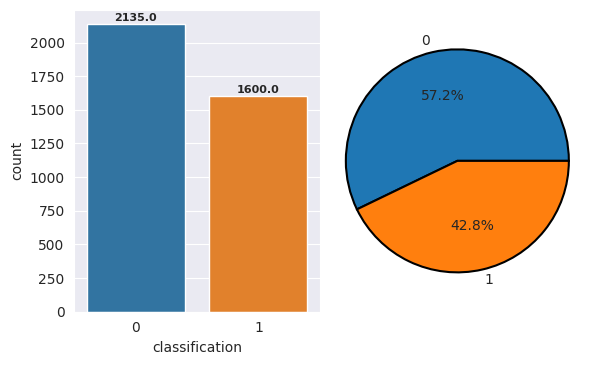

In [14]:
# Let's visualize how the target variable is distributed.
fig,ax = plt.subplots(1,2,figsize = (6,4))

sns.countplot(data,
              x = 'classification',
              ax = ax[0])

for rect in ax[0].patches:
  height = rect.get_height()
  ax[0].annotate(text = f'{height}',
              xy = (rect.get_x()+rect.get_width()/2, height-20),
              xytext = (0,3),
              textcoords = 'offset points',
              ha = 'center',
              va = 'bottom',
              size = 8,
              weight = 'bold')

df_plot_pie = data['classification'].value_counts().to_frame()
df_plot_pie.index = df_plot_pie.index.astype(str)
labels = df_plot_pie.index.to_list()
values = df_plot_pie.iloc[:,0]

ax[1].pie(x = values, labels = labels, autopct = '%.1f%%', wedgeprops = {'linewidth':1.5, 'edgecolor':'black'})
ax[1].axis('equal')

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

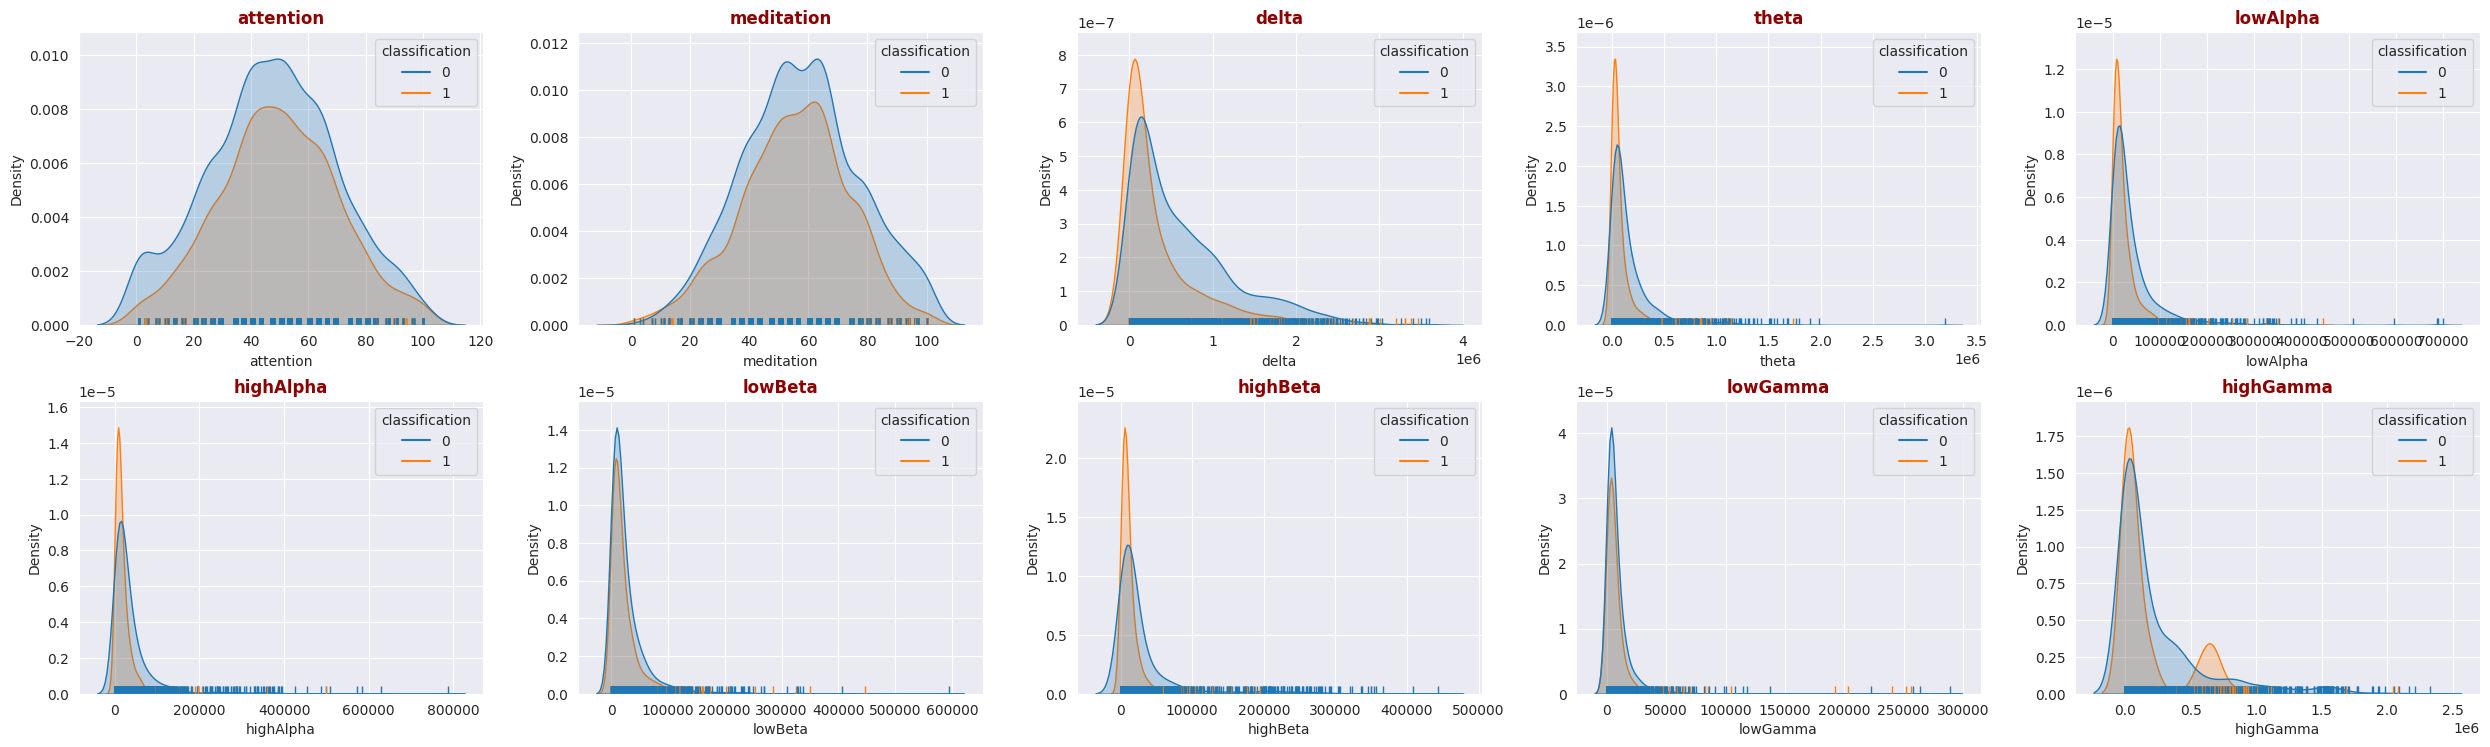

In [15]:
# Let's visualize how each variable is distributed with respect to the target variable.
fig,ax = plt.subplots(nrows = 2, ncols = 5, figsize = (25,8))
ax = ax.flat

for i,col in enumerate(cols_to_plot):

  sns.kdeplot(data,
              x = col,
              fill = True,
              hue = 'classification',
              ax = ax[i])
  sns.rugplot(data,
              x = col,
              hue = 'classification',
              ax = ax[i])
  ax[i].set_title(f'{col}', fontsize = 12, fontweight = 'bold', color = 'darkred')

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

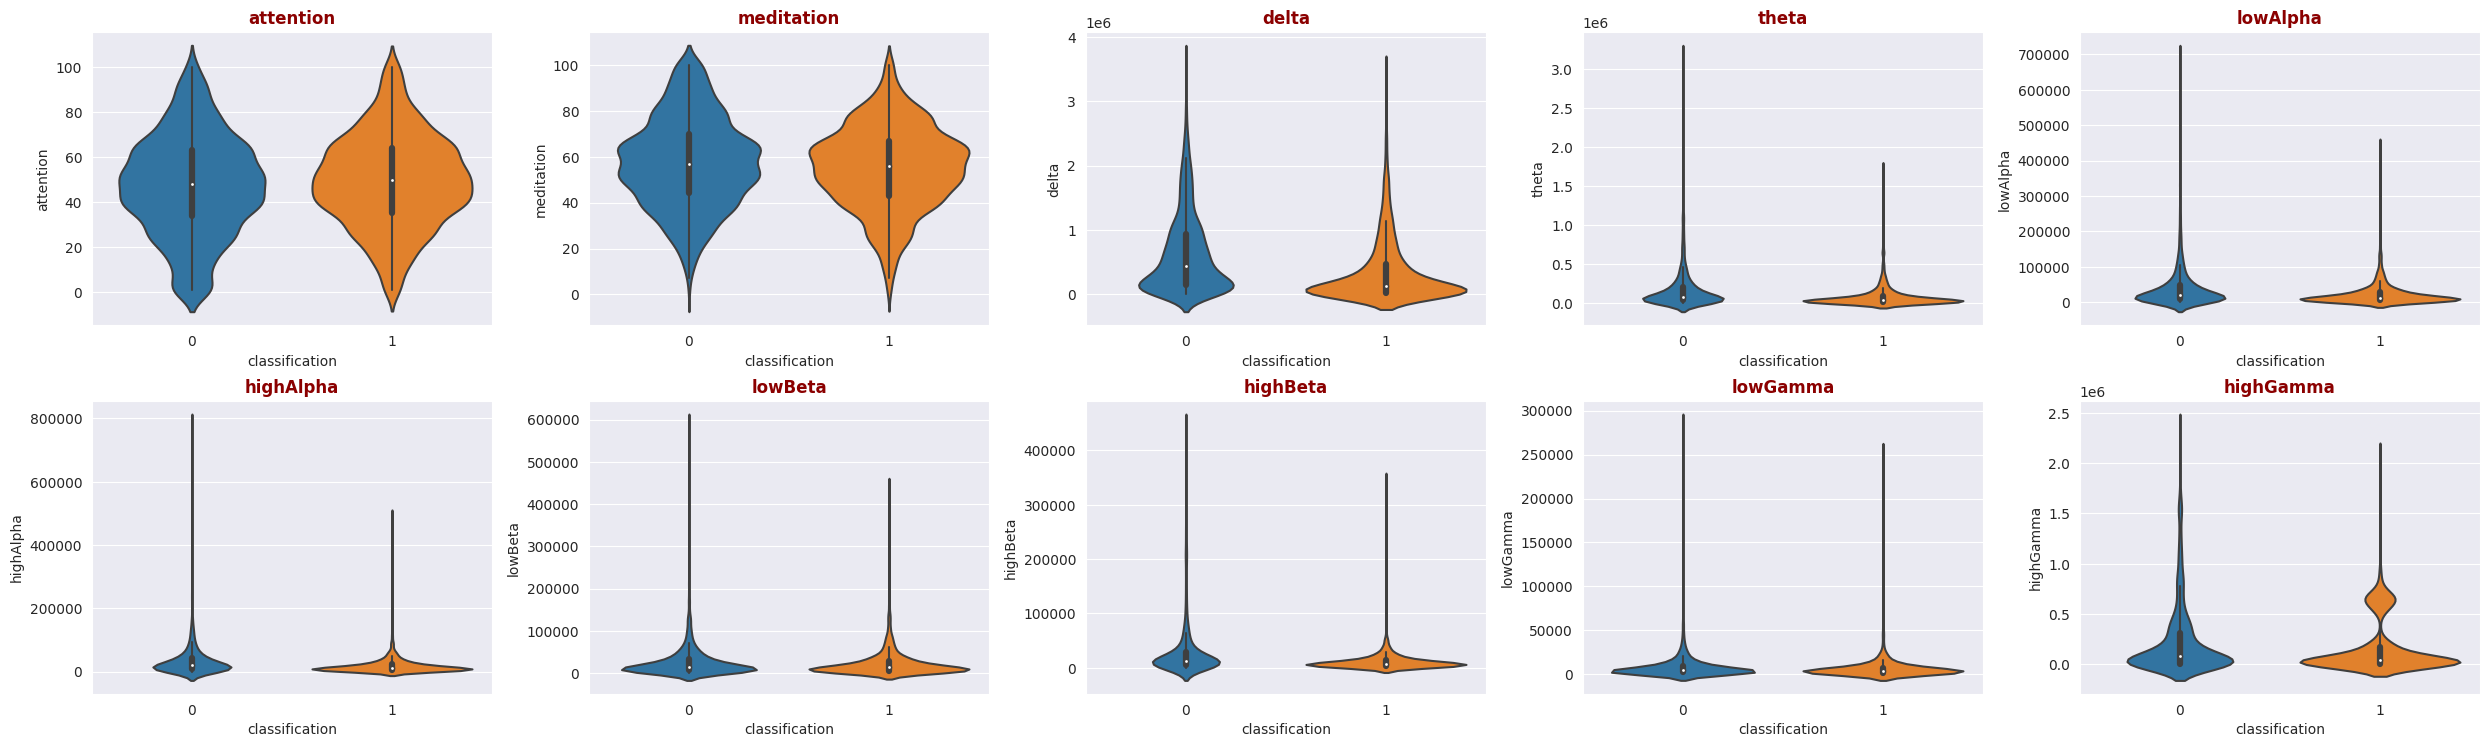

In [16]:
# Let's visualize how each variable is distributed with respect to the target variable.
fig,ax = plt.subplots(nrows = 2, ncols = 5, figsize = (25,8))
ax = ax.flat

for i,col in enumerate(cols_to_plot):

  sns.violinplot(data,
              x = 'classification',
              y = col,
              ax = ax[i])

  ax[i].set_title(f'{col}', fontsize = 12, fontweight = 'bold', color = 'darkred')

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

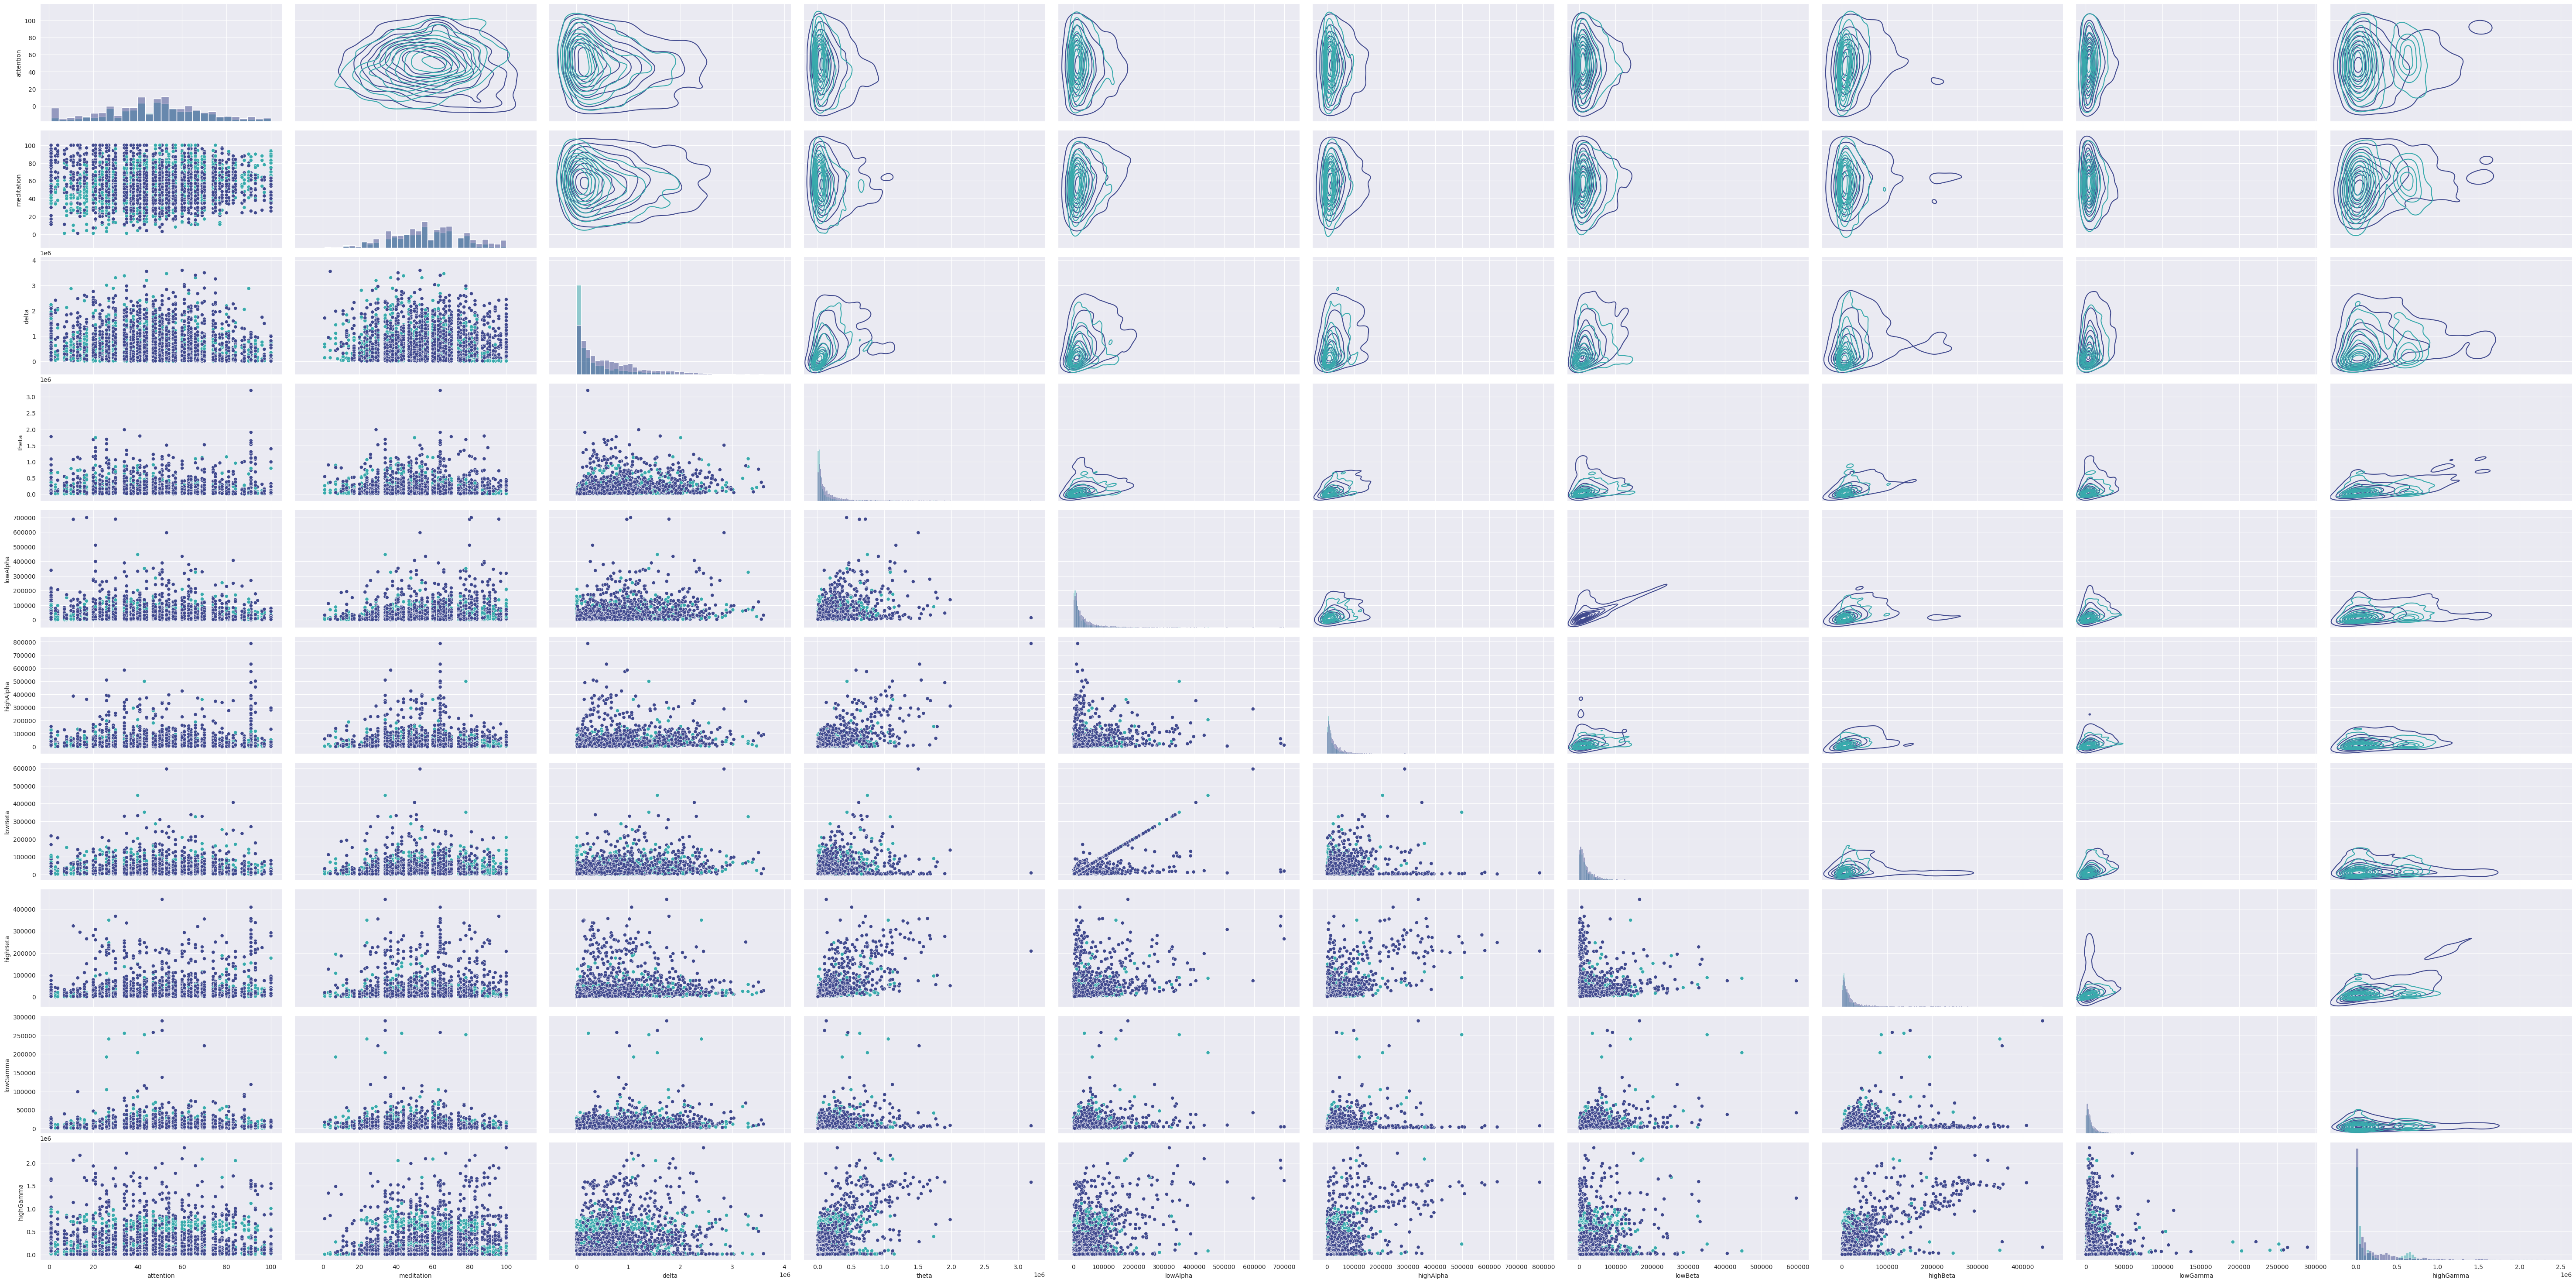

In [17]:
# Let's visualize some pattern between each pair of numerical variables according to the target variable.
g = sns.PairGrid(data, hue = 'classification', palette = 'mako', height = 3., aspect = 2.0)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.fig.show()

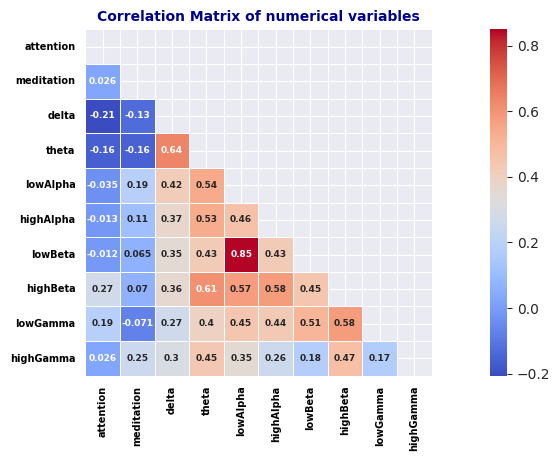

In [18]:
# Now let's visualize the correlation between each pair of numerical variables.
# We will use the Spearman correlation since the data for all numerical variables do not come from a normal distribution.
corr_matrix = data[cols_to_plot].corr(method = 'spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

fig,ax = plt.subplots(figsize = (15,4.5))
sns.heatmap(corr_matrix,
            annot = True,
            cmap = 'coolwarm',
            annot_kws = {'fontsize':6.5, 'fontweight':'bold'},
            linewidths = 0.7,
            linecolor = 'white',
            square = True,
            mask = mask,
            ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
ax.set_title('Correlation Matrix of numerical variables', fontsize = 10, fontweight = 'bold', color = 'darkblue')
fig.show()

We see that there is a high relationship between the variable **lowAlpha** and **lowBeta** with a value of **0.85**.

# **5. Preprocessing**

In [19]:
# We separate the independent and dependent variables (target).
X = data.drop(['classification'], axis = 1)
y = data['classification']

In [20]:
# We divide into training and test set.
SEED = 42
X_train, X_test, y_train, y_test = tts(X,
                                       y,
                                       test_size = 0.3,
                                       random_state = SEED,
                                       shuffle = True,
                                       stratify = y)

print(f'Training data size: {X_train.shape}')
print(f'Testing data size: {X_test.shape}')

Training data size: (2614, 10)
Testing data size: (1121, 10)


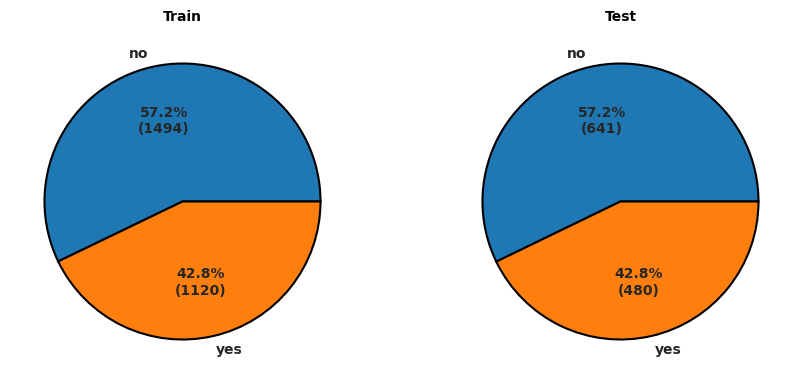

In [21]:
# Visualization of the objective variable in the training and test set.
df_pct_train = y_train.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_train = df_pct_train.rename(columns = {'y':'count'})

labels_train = df_pct_train.index.to_list()
values_train = df_pct_train.iloc[:,0]

df_pct_test = y_test.value_counts().to_frame().rename(index = {0:'no', 1:'yes'})
df_pct_test = df_pct_test.rename(columns = {'y':'count'})

labels_test = df_pct_test.index.to_list()
values_test = df_pct_test.iloc[:,0]


fig,axes = plt.subplots(1,2,figsize = (9,4))

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"


axes[0].pie(x = values_train, labels = labels_train, autopct = autopct_fun(values_train),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[0].set_title('Train', fontsize = 10, fontweight = 'bold', color = 'black')

axes[1].pie(x = values_test, labels = labels_test, autopct = autopct_fun(values_test),
            wedgeprops = {'linewidth':1.5, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'})
axes[1].set_title('Test', fontsize = 10, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

We see that there is an imbalance in the classes, for this we will perform an oversampling with the **SMOTE** method to balance the classes, but first we will scale our training data.

In [22]:
# We will use StandardScaler in this case.
scaler = StandardScaler()

X_train_prep = scaler.fit_transform(X_train)
X_train_prep_df = pd.DataFrame(X_train_prep, columns = scaler.feature_names_in_)

X_test_prep = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test_prep, columns = scaler.feature_names_in_)

In [23]:
# Oversampling
smote = SMOTE(random_state = SEED)

X_train_df, y_train_smote = smote.fit_resample(X_train_prep_df, y_train)

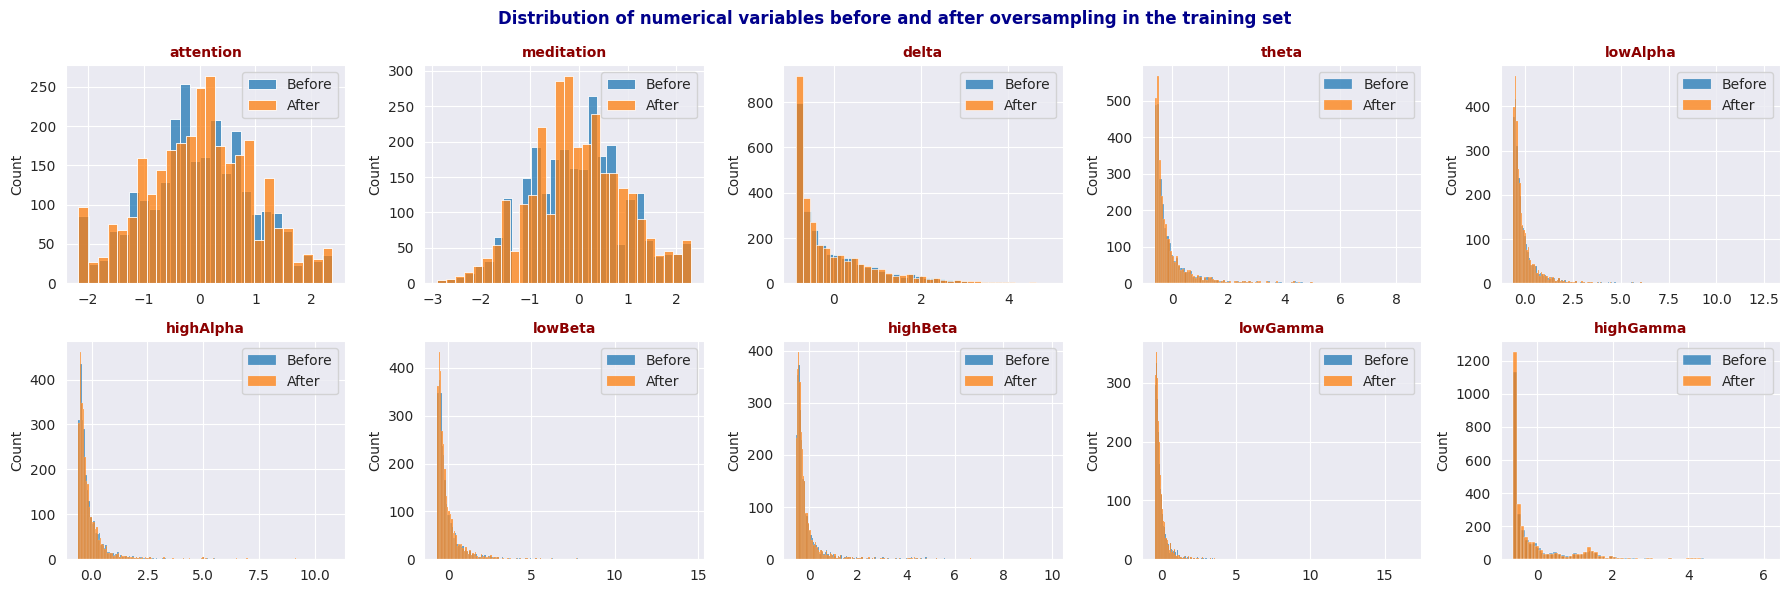

In [24]:
fig,ax = plt.subplots(2,5,figsize = (18,6))
ax = ax.flat

for i, col in enumerate(cols_to_plot):
  sns.histplot(X_train_prep_df[col], ax = ax[i], label = "Before")
  sns.histplot(X_train_df[col], ax = ax[i], label = "After")
  ax[i].set_xlabel('')
  ax[i].set_title(f'{col}', fontsize = 10, fontweight = 'bold', color = 'darkred')
  ax[i].legend()

fig.suptitle('Distribution of numerical variables before and after oversampling in the training set', fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.tight_layout()
fig.show()

In [25]:
# Now let's visualize that the classes are balanced.
y_train_smote.value_counts(normalize = True)

classification
0    0.5
1    0.5
Name: proportion, dtype: float64

# **6. Models**

We define the candidate models to choose.

In [26]:
# Estimators for the VotingClassifier and StackingClassifier.
e1 = XGBClassifier(objective = 'binary:logistic', random_state = SEED,
                   tree_method = "exact", booster = 'gbtree')
e2 = LGBMClassifier(random_state = SEED, verbose = -1)
e3 = CatBoostClassifier(random_state = SEED, verbose = 0)

voting1 = VotingClassifier(estimators = [('lgbm', e2), ('cb', e3)])

In [27]:
# We define the models to use.
lr = LogisticRegression(random_state = SEED)

rf = RandomForestClassifier(random_state = SEED)

et = ExtraTreesClassifier(bootstrap = True, random_state = SEED)

svc = SVC(random_state = SEED)

knn = KNeighborsClassifier()

hgb = HistGradientBoostingClassifier(random_state = SEED)

xgb = XGBClassifier(objective = 'binary:logistic', tree_method = "exact",
                    random_state = SEED, booster = 'gbtree')

lgbm = LGBMClassifier(random_state = SEED, verbose = -1)

cb = CatBoostClassifier(random_state = SEED, verbose = 0)

voting = VotingClassifier(estimators = [('lgbm', e2), ('cb', e3)])

stacking = StackingClassifier(estimators = [('lgbm', e2), ('cb', e3)],
                              final_estimator = voting1, stack_method='predict')

# We create a dictionary where we store our models with their respective names.
base_models = {'Logistic_Regression':lr,
               'Random_Forest':rf,
               'Extra_Trees':et,
               'SVC':svc,
               'KNN':knn,
               'XGB':xgb,
               'LGBM':lgbm,
               'CatBoost':cb,
               'Voting':voting,
               'Stacking':stacking,
               'HistGrad':hgb}

In [28]:
## Training

# Dictionary where we will store the metrics of each model.
accuracy_train = {}
accuracy_test = {}

confusion_matrix_train = {}
confusion_matrix_test = {}

for model_name, model in base_models.items():
  start = time.time()
  model.fit(X_train_df, y_train_smote)
  end = time.time()
  print(f'* {model_name}: {end-start} seconds')
  y_pred_train = model.predict(X_train_df)
  y_pred_test = model.predict(X_test_df)
  accuracy_train[model_name] = accuracy_score(np.array(y_train_smote), y_pred_train)
  accuracy_test[model_name] = accuracy_score(np.array(y_test), y_pred_test)
  confusion_matrix_train[model_name] = confusion_matrix(np.array(y_train_smote), y_pred_train)
  confusion_matrix_test[model_name] = confusion_matrix(np.array(y_test), y_pred_test)

* Logistic_Regression: 0.02951192855834961 seconds
* Random_Forest: 1.0816736221313477 seconds
* Extra_Trees: 0.4511539936065674 seconds
* SVC: 0.35663294792175293 seconds
* KNN: 0.005368947982788086 seconds
* XGB: 0.4164915084838867 seconds
* LGBM: 0.6375515460968018 seconds
* CatBoost: 3.3045783042907715 seconds
* Voting: 3.7160332202911377 seconds
* Stacking: 22.469680786132812 seconds
* HistGrad: 0.4975700378417969 seconds


# **7. Metric: Accuracy**

In [29]:
# We create a dataframe showing the accuracy results in training and testing.
df_accuracy_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index').rename(columns = {0:'Train'})
df_accuracy_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index').rename(columns = {0:'Test'})
df_accuracy = pd.merge(df_accuracy_train, df_accuracy_test, left_index = True, right_index = True)
df_accuracy = df_accuracy.sort_values(['Train', 'Test'], ascending = False)
df_accuracy

Train      Test
Random_Forest        1.000000  0.787690
XGB                  1.000000  0.787690
Extra_Trees          1.000000  0.786798
LGBM                 0.985274  0.810883
HistGrad             0.983601  0.808207
Voting               0.968206  0.826940
Stacking             0.968206  0.826940
CatBoost             0.948795  0.818020
KNN                  0.827644  0.696699
SVC                  0.745984  0.705620
Logistic_Regression  0.683735  0.662801

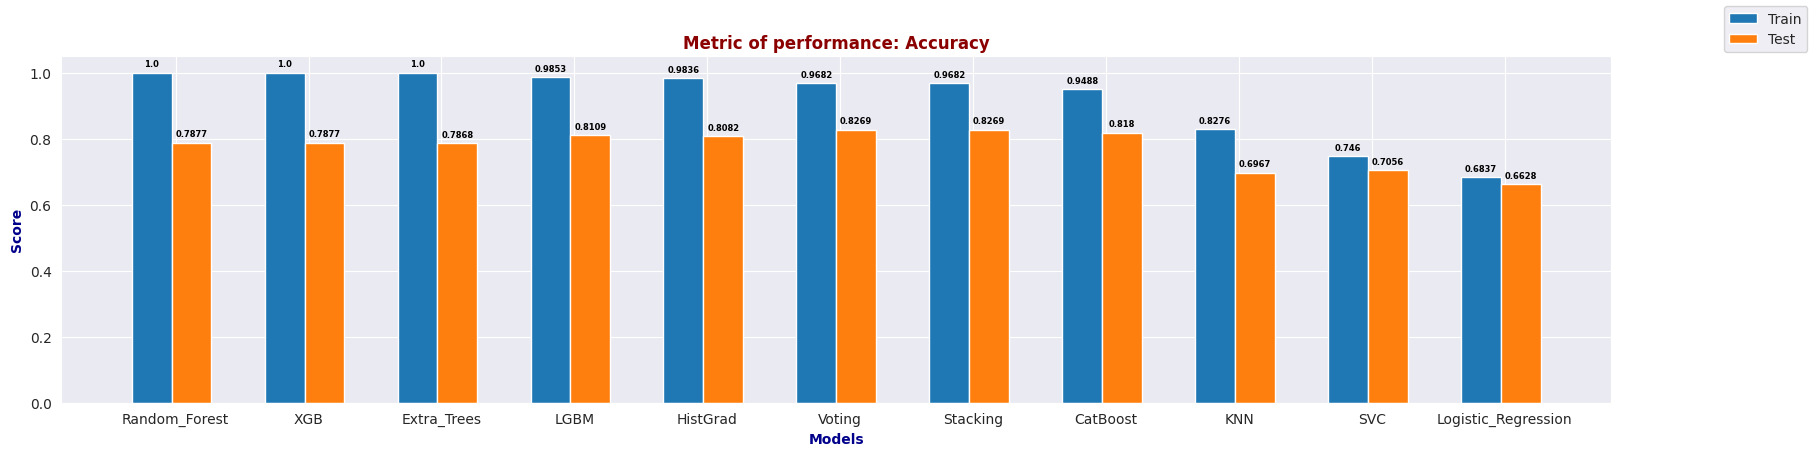

In [30]:
# Let's visualize the metric in a bar graph.
fig,ax = plt.subplots(figsize = (20, 4.5))
n = len(df_accuracy.index)
x = np.arange(n)
width = 0.3

rects1 = ax.bar(x = x-width, height = df_accuracy.iloc[:,0], width = width)
rects2 = ax.bar(x = x, height = df_accuracy.iloc[:,1], width = width)
ax.set_xticks(x-0.12, df_accuracy.index.to_list())
ax.set_xlabel('Models', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Score', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Metric of performance: Accuracy', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = f'{round(height,4)}',
                xy = (rect.get_x()+rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                size = 6,
                weight = 'bold',
                color = 'black')

autolabel(rects1)
autolabel(rects2)
fig.legend(["Train", "Test"])
fig.show()

- **Confusion Matrix**

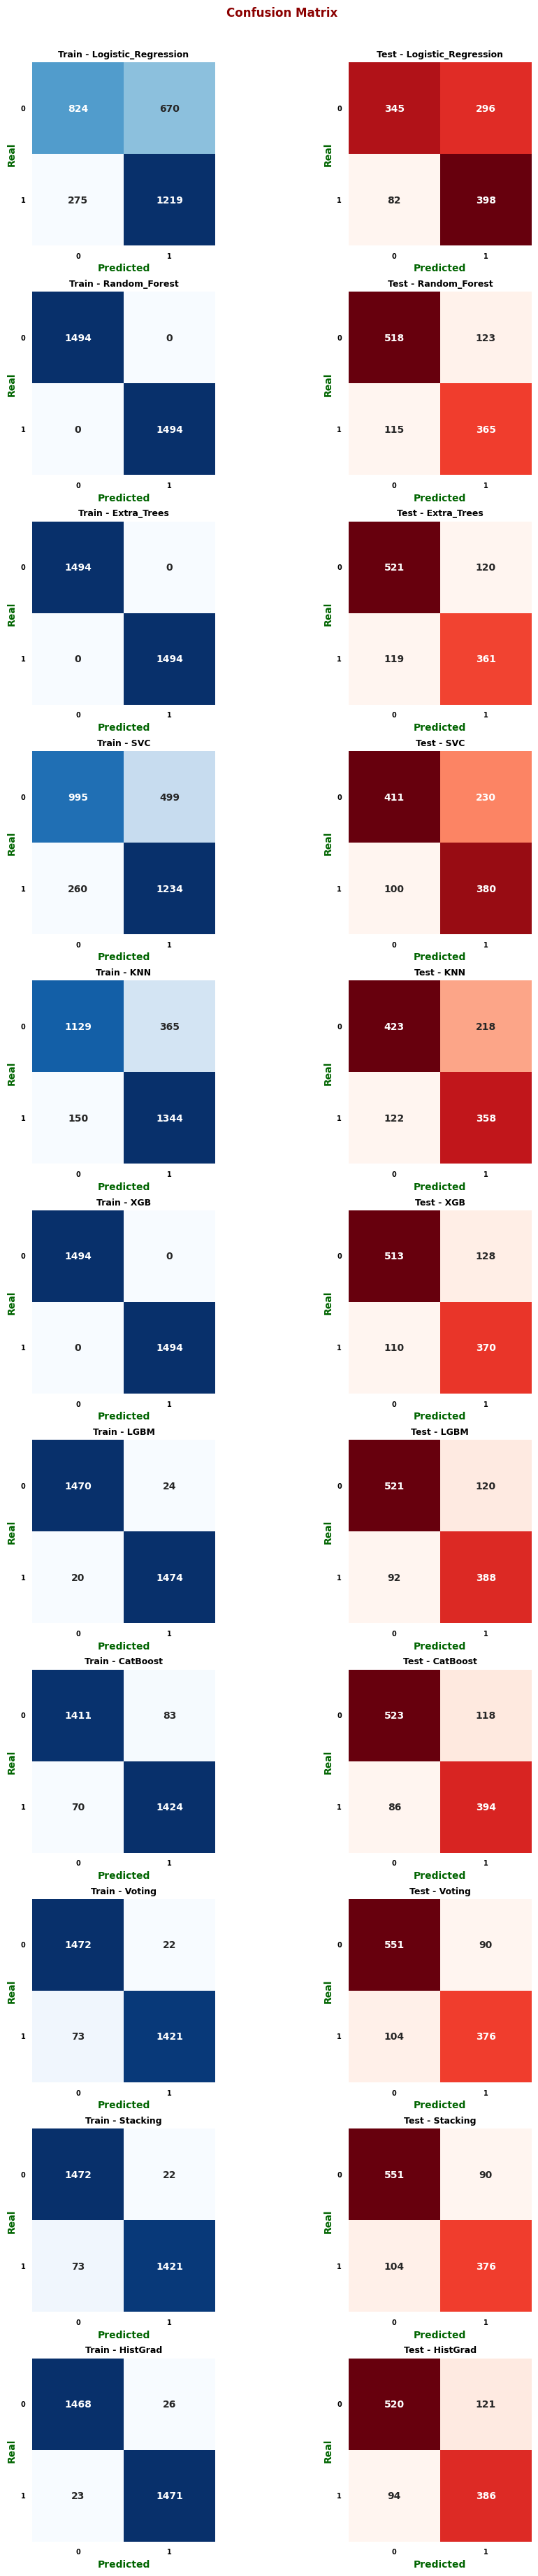

In [31]:
# Now let's visualize the confusion matrix that was generated from each model in training and testing.
fig,ax = plt.subplots(nrows = 11, ncols = 2, figsize = (10, 40))

for p, ((model_name_train,cmx_train), (model_name_test, cmx_test)) in enumerate(zip(confusion_matrix_train.items(), confusion_matrix_test.items())):

  sns.heatmap(cmx_train, annot = True, square = True, cmap = 'Blues', fmt = '',annot_kws = {'fontweight':'bold'}, cbar = False, ax = ax[p,0])
  ax[p,0].set_title(f'Train - {model_name_train}', fontsize = 9, fontweight = 'bold', color = 'black')
  ax[p,0].tick_params('y', rotation = 0)
  ax[p,0].set_xticklabels(ax[p,0].get_xticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,0].set_yticklabels(ax[p,0].get_yticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,0].set_xlabel('Predicted', fontsize = 10, fontweight = 'bold', color = 'darkgreen')
  ax[p,0].set_ylabel('Real', fontsize = 10, fontweight = 'bold', color = 'darkgreen')

  sns.heatmap(cmx_test, annot = True, square = True, cmap = 'Reds', fmt = '', annot_kws = {'fontweight':'bold'}, cbar = False, ax = ax[p,1])
  ax[p,1].set_title(f'Test - {model_name_test}', fontsize = 9, fontweight = 'bold', color = 'black')
  ax[p,1].tick_params('y', rotation = 0)
  ax[p,1].set_xticklabels(ax[p,1].get_xticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,1].set_yticklabels(ax[p,1].get_yticklabels(), fontsize = 7, fontweight = 'bold', color = 'black')
  ax[p,1].set_xlabel('Predicted', fontsize = 10, fontweight = 'bold', color = 'darkgreen')
  ax[p,1].set_ylabel('Real', fontsize = 10, fontweight = 'bold', color = 'darkgreen')


fig.suptitle('Confusion Matrix', fontsize = 12, fontweight = 'bold', color = 'darkred', y = 0.92)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # Required for HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Define your X_train_df and y_train_smote data

# Define a dictionary to store hyperparameters for each model
model_hyperparameters = {
    'Logistic_Regression': {'C': [0.1, 1, 10]},
    'Random_Forest': {'n_estimators': [50, 100, 200]},
    'Extra_Trees': {'n_estimators': [50, 100, 200]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'XGB': {'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5]},
    'LGBM': {'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5]},
    'CatBoost': {'n_estimators': [50, 100, 200], 'depth': [3, 4, 5]},
}

# Dictionary where we will store the metrics of each model.
accuracy_train = {}
accuracy_test = {}

confusion_matrix_train = {}
confusion_matrix_test = {}

best_estimators = {}  # Store the best estimators after hyperparameter tuning

for model_name, model in base_models.items():
    # Hyperparameter tuning using GridSearchCV
    if model_name in model_hyperparameters:
        params = model_hyperparameters[model_name]
        grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
        grid_search.fit(X_train_df, y_train_smote)
        best_estimators[model_name] = grid_search.best_estimator_
    else:
        best_estimators[model_name] = model

    # Cross-validation
    start = time.time()
    scores = cross_val_score(best_estimators[model_name], X_train_df, y_train_smote, cv=5, scoring='accuracy')
    end = time.time()
    
    print(f'* {model_name} (Cross-Validation):')
    print(f'  - Mean Accuracy: {np.mean(scores):.4f}')
    print(f'  - Time: {end - start:.2f} seconds')

    # Fit the best estimator on the full training data
    best_estimators[model_name].fit(X_train_df, y_train_smote)

    # Evaluate on the test set
    y_pred_train = best_estimators[model_name].predict(X_train_df)
    y_pred_test = best_estimators[model_name].predict(X_test_df)
    accuracy_train[model_name] = accuracy_score(y_train_smote, y_pred_train)
    accuracy_test[model_name] = accuracy_score(y_test, y_pred_test)
    confusion_matrix_train[model_name] = confusion_matrix(y_train_smote, y_pred_train)
    confusion_matrix_test[model_name] = confusion_matrix(y_test, y_pred_test)

# Rest of your code for visualization of results...

# You can access the best hyperparameters and best estimators like this:
for model_name, best_estimator in best_estimators.items():
    if model_name in model_hyperparameters:
        print(f'Best hyperparameters for {model_name}: {best_estimator.get_params()}')

# Further analysis and visualization...

* Logistic_Regression (Cross-Validation):
  - Mean Accuracy: 0.6787
  - Time: 0.20 seconds
* Random_Forest (Cross-Validation):
  - Mean Accuracy: 0.8019
  - Time: 8.55 seconds
* Extra_Trees (Cross-Validation):
  - Mean Accuracy: 0.8096
  - Time: 4.16 seconds
* SVC (Cross-Validation):
  - Mean Accuracy: 0.7436
  - Time: 1.49 seconds
* KNN (Cross-Validation):
  - Mean Accuracy: 0.7356
  - Time: 0.37 seconds
* XGB (Cross-Validation):
  - Mean Accuracy: 0.8076
  - Time: 4.68 seconds
* LGBM (Cross-Validation):
  - Mean Accuracy: 0.8042
  - Time: 2.58 seconds
* CatBoost (Cross-Validation):
  - Mean Accuracy: 0.7982
  - Time: 2.34 seconds
* Voting (Cross-Validation):
  - Mean Accuracy: 0.8146
  - Time: 18.34 seconds
* Stacking (Cross-Validation):
  - Mean Accuracy: 0.8146
  - Time: 106.01 seconds
* HistGrad (Cross-Validation):
  - Mean Accuracy: 0.8039
  - Time: 2.47 seconds
Best hyperparameters for Logistic_Regression: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'in

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# ...

# Dictionary where we will store the metrics of each model.
accuracy_train = {}
accuracy_test = {}
precision_train = {}
precision_test = {}
recall_train = {}
recall_test = {}
f1_train = {}
f1_test = {}
roc_auc_train = {}
roc_auc_test = {}
confusion_matrix_train = {}
confusion_matrix_test = {}

best_estimators = {}  # Store the best estimators after hyperparameter tuning

for model_name, model in base_models.items():
    # Hyperparameter tuning using GridSearchCV
    if model_name in model_hyperparameters:
        params = model_hyperparameters[model_name]
        grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
        grid_search.fit(X_train_df, y_train_smote)
        best_estimators[model_name] = grid_search.best_estimator_
    else:
        best_estimators[model_name] = model

    # Cross-validation
    start = time.time()
    scores = cross_val_score(best_estimators[model_name], X_train_df, y_train_smote, cv=5, scoring='accuracy')
    end = time.time()
    
    print(f'* {model_name} (Cross-Validation):')
    print(f'  - Mean Accuracy: {np.mean(scores):.4f}')
    print(f'  - Time: {end - start:.2f} seconds')

    # Fit the best estimator on the full training data
    best_estimators[model_name].fit(X_train_df, y_train_smote)

    # Evaluate on the test set
    y_pred_train = best_estimators[model_name].predict(X_train_df)
    y_pred_test = best_estimators[model_name].predict(X_test_df)
    
    # Compute and store additional metrics
    accuracy_train[model_name] = accuracy_score(y_train_smote, y_pred_train)
    accuracy_test[model_name] = accuracy_score(y_test, y_pred_test)
    
    precision_train[model_name] = precision_score(y_train_smote, y_pred_train)
    precision_test[model_name] = precision_score(y_test, y_pred_test)
    
    recall_train[model_name] = recall_score(y_train_smote, y_pred_train)
    recall_test[model_name] = recall_score(y_test, y_pred_test)
    
    f1_train[model_name] = f1_score(y_train_smote, y_pred_train)
    f1_test[model_name] = f1_score(y_test, y_pred_test)
    
    roc_auc_train[model_name] = roc_auc_score(y_train_smote, y_pred_train)
    roc_auc_test[model_name] = roc_auc_score(y_test, y_pred_test)
    
    confusion_matrix_train[model_name] = confusion_matrix(y_train_smote, y_pred_train)
    confusion_matrix_test[model_name] = confusion_matrix(y_test, y_pred_test)

# Rest of your code for visualization of results...

# Print and visualize the additional evaluation metrics
for model_name in base_models.keys():
    print(f'{model_name} Metrics:')
    print(f'  Train Accuracy: {accuracy_train[model_name]:.4f}')
    print(f'  Test Accuracy: {accuracy_test[model_name]:.4f}')
    print(f'  Train Precision: {precision_train[model_name]:.4f}')
    print(f'  Test Precision: {precision_test[model_name]:.4f}')
    print(f'  Train Recall: {recall_train[model_name]:.4f}')
    print(f'  Test Recall: {recall_test[model_name]:.4f}')
    print(f'  Train F1-Score: {f1_train[model_name]:.4f}')
    print(f'  Test F1-Score: {f1_test[model_name]:.4f}')
    print(f'  Train ROC AUC: {roc_auc_train[model_name]:.4f}')
    print(f'  Test ROC AUC: {roc_auc_test[model_name]:.4f}')
    print('\n')

# Continue with the rest of your code for visualization of results...


* Logistic_Regression (Cross-Validation):
  - Mean Accuracy: 0.6787
  - Time: 0.16 seconds
* Random_Forest (Cross-Validation):
  - Mean Accuracy: 0.8019
  - Time: 8.53 seconds
* Extra_Trees (Cross-Validation):
  - Mean Accuracy: 0.8096
  - Time: 4.18 seconds
* SVC (Cross-Validation):
  - Mean Accuracy: 0.7436
  - Time: 1.49 seconds
* KNN (Cross-Validation):
  - Mean Accuracy: 0.7356
  - Time: 0.35 seconds
* XGB (Cross-Validation):
  - Mean Accuracy: 0.8076
  - Time: 4.87 seconds
* LGBM (Cross-Validation):
  - Mean Accuracy: 0.8042
  - Time: 2.51 seconds
* CatBoost (Cross-Validation):
  - Mean Accuracy: 0.7982
  - Time: 2.53 seconds
* Voting (Cross-Validation):
  - Mean Accuracy: 0.8146
  - Time: 18.01 seconds
* Stacking (Cross-Validation):
  - Mean Accuracy: 0.8146
  - Time: 107.49 seconds
* HistGrad (Cross-Validation):
  - Mean Accuracy: 0.8039
  - Time: 2.62 seconds
Logistic_Regression Metrics:
  Train Accuracy: 0.6847
  Test Accuracy: 0.6646
  Train Precision: 0.6460
  Test Precisio